# Experiments simulation 7


## Imports

In [1]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from PyDistances.mixed import FastGGowerDistMatrix
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_8

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_8 import get_config as get_config_exp_1_sim_8
from config_experiment_3_simulation_8 import get_config as get_config_exp_3_sim_8
from config_experiment_4_simulation_8 import get_config as get_config_exp_4_sim_8


## Data Simulation

In [4]:
X, y, outliers_idx = get_simulation_8(random_state=123, return_outlier_idx=True)

In [5]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [19]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,5.127358,-3.128741,-3.236879,2.182968,1,0,3,2
1,6.034537,-2.864370,-4.820211,-0.233997,1,0,3,2
2,-22.159024,-16.771971,-4.882883,-0.024268,1,0,3,3
3,5.028627,-4.822047,-7.192620,0.742097,1,0,3,2
4,4.248280,-1.535007,-4.351140,2.985494,1,0,3,0


In [20]:
X.shape

(300000, 8)

In [21]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.2, 1: 0.3, 2: 0.5}


In [22]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-18.888221,12.926539,14485,285515,0.048283,0.951717
"""X2""",-14.406051,4.516171,15069,284931,0.05023,0.94977
"""X3""",-11.949016,8.380824,831,299169,0.00277,0.99723
"""X4""",-6.735628,10.642822,1181,298819,0.003937,0.996063


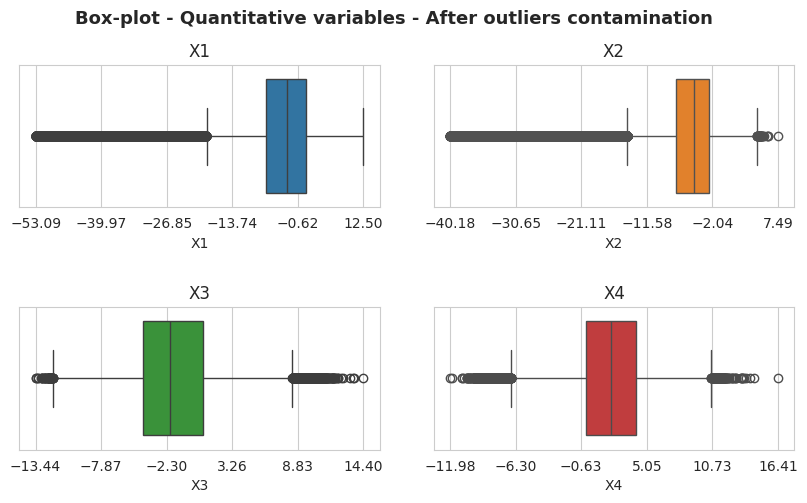

In [23]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [24]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

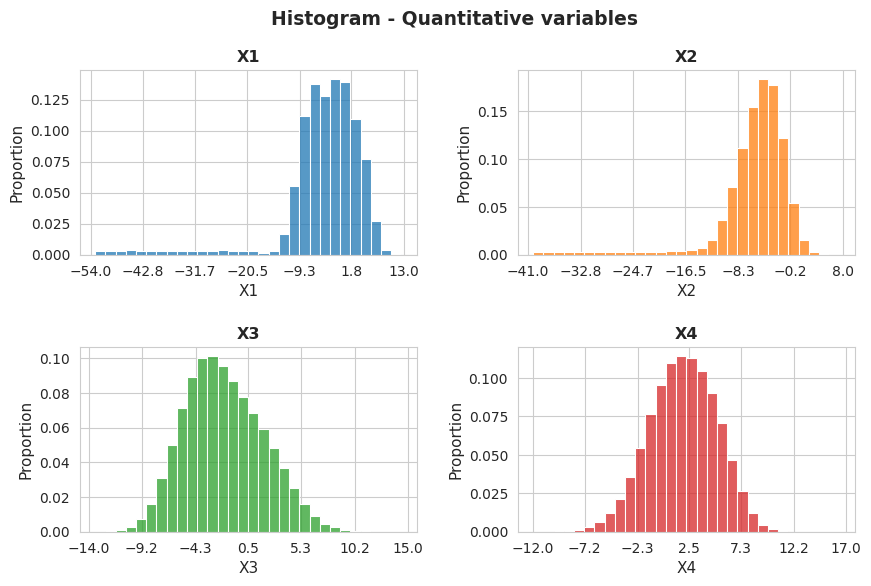

In [25]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

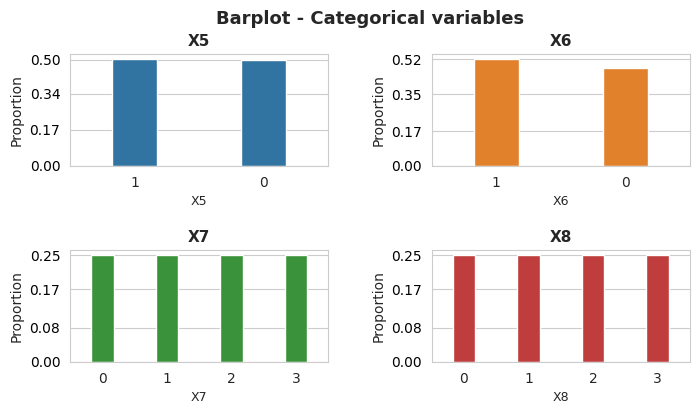

In [26]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [27]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.822329,-0.312593,0.103997
X2,0.822329,1.000000,-0.160261,0.158363
X3,-0.312593,-0.160261,1.000000,-0.177914
X4,0.103997,0.158363,-0.177914,1.000000


In [28]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.17
Proportion of pair-wise correlations in [0.30, 0.60]:  0.17
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.67


## Experiment 1: Accuracy and computation time for Fast k-medoids (section 3.2)

In [45]:
run_experiment_1 = True

In [ ]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251009_181109'
    
    experiment_1_config = get_config_exp_1_sim_8()

    X, y = get_simulation_8(random_state=experiment_random_state, return_outlier_idx=False)


In [ ]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print("chunk_id:", chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                      X=X, 
                                                      y=y,
                                                      random_state=random_state,
                                                      metric=balanced_accuracy_score
                                                      )
            
        # Save results
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization 
## IBiDat Server: 80*23 mins = 1760 mins
# 1 realization = 27 mins

chunks:   0%|          | 0/1 [00:00<?, ?chunks/s]

chunk_id: 0
random_state_chunk: [53]
random_state: 53
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks: 100%|██████████| 1/1 [27:31<00:00, 1651.99s/chunks]


In [52]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    file_id = '20251009_181109'
    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_1', 'simulation_7')
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [53]:
# Open merged/joined results 
file_id = '20251009_181109'
results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [54]:
experiment_1_config = get_config_exp_1_sim_8()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [55]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

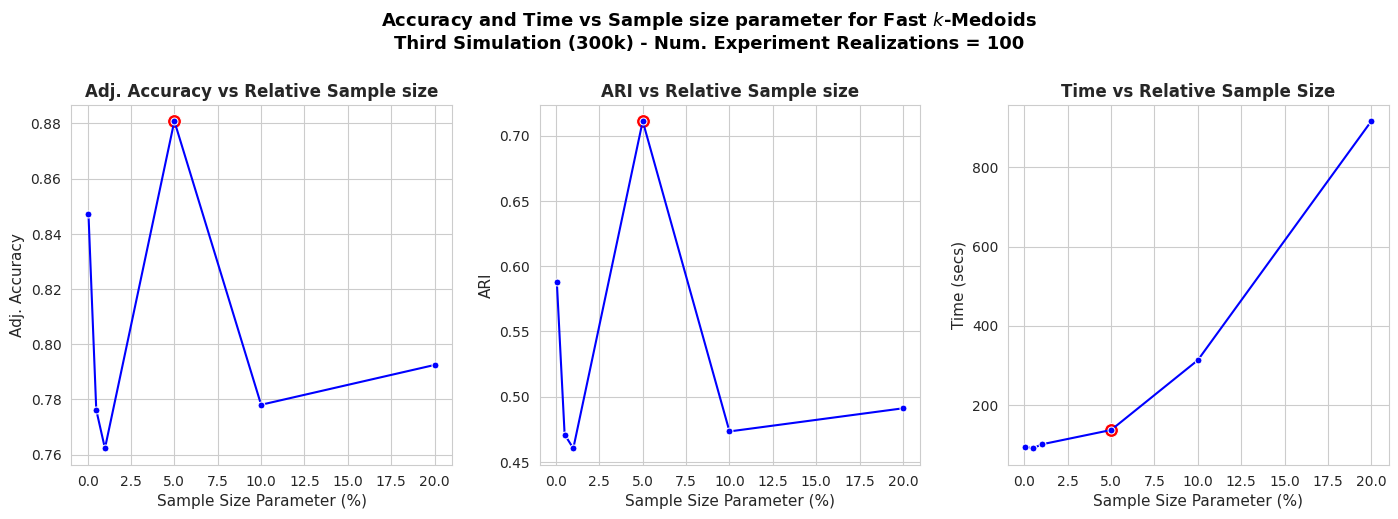

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs Relative Sample size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs Relative Sample size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs Relative Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs Sample size parameter for Fast $k$-Medoids\nSeventh Simulation (300k) - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [57]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,94.287650,0.847270,0.588048
0.0050,89.935935,0.776136,0.470864
0.0100,100.060231,0.762244,0.460294
0.0500,136.334801,0.880807,0.711111
0.1000,312.840455,0.778035,0.473264
0.2000,916.999413,0.792461,0.490990


In [59]:
print(best_frac_sample_size)

0.05



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids (section 3.4)

In [6]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_3', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251009_181109'

    experiment_3_config = get_config_exp_3_sim_8()

    X, y = get_simulation_8(random_state=experiment_random_state, return_outlier_idx=False)

In [ ]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**experiment_3_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization
## IBiDat server: 3000 mins 
## 1 realization = 30 mins

  0%|          | 0/1 [00:00<?, ?it/s]

random_state_chunk: [53]
random_state: 53
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:44<00:00, 20.94s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:06<00:00, 25.28s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:42<00:00, 32.46s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:37<00:00,  9.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:37<00:00,  9.79s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:48<00:00, 10.84s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.86s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:50<00:00,  5.53s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:45<00:00,  2.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


frac_sample_size: 0.15


100%|██████████| 1/1 [29:02<00:00, 1742.73s/it]


In [9]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_3', 'simulation_7')
    chunk_ids = range(len(os.listdir(results_folder_path)))
    file_id = '20251009_181109'    
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [10]:
# Open merged/joined results 
file_id = '20251009_181109'
results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [11]:
experiment_3_config = get_config_exp_3_sim_8()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

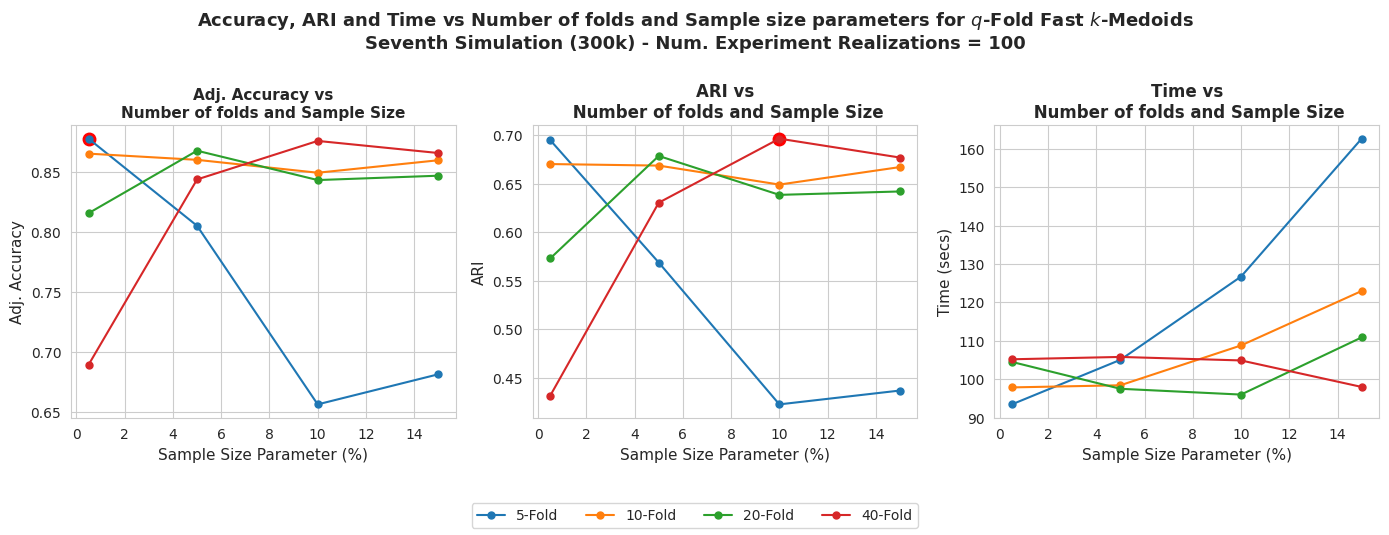

In [12]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size = 11)
ax1.set_ylabel("Adj. Accuracy", size = 11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size = 11)
ax2.set_ylabel("ARI", size = 11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=12, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size = 11)
ax3.set_ylabel("Time (secs)", size = 11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of folds and Sample size parameters for $q$-Fold Fast $k$-Medoids\nSeventh Simulation (300k) - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [13]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.878010,0.695064,93.437357
1,5,0.050,0.805323,0.568698,105.045232
2,5,0.100,0.656377,0.422288,126.712557
3,5,0.150,0.681477,0.436576,162.633549
4,10,0.005,0.865520,0.670328,97.856940
5,10,0.050,0.860347,0.668740,98.413978
6,10,0.100,0.849593,0.649136,108.783000
7,10,0.150,0.860000,0.667219,122.965879
8,20,0.005,0.815820,0.572882,104.500178
9,20,0.050,0.867960,0.678697,97.497030


In [14]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.002 
 best_n_splits 5.0 
 best_frac_sample_size 0.005


## Experiment 4: Empirical comparison to other existing algorithms (section 3.5)

In [32]:
run_experiment_4 = True

In [33]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

experiment_4_config = get_config_exp_4_sim_8()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size_fast_kmedoids'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size_fold_fast_kmedoids'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [34]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251010_131308'

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_8(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models,
                metric=balanced_accuracy_score
            )

        # Save results
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 
## Personal compute: 1370 + 481  mins =  hours 

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.32s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [03:14<00:00, 38.99s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:57<00:00, 35.49s/it]


len y_pred: 3
random_state: 35084
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 27.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:15<00:00, 27.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:11<00:00, 26.40s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:29<00:00, 29.81s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.12s/it]


len y_pred: 3
random_state: 11427
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:10<00:00, 26.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:11<00:00, 26.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:07<00:00, 25.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:32<00:00, 30.58s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:26<00:00, 29.32s/it]


len y_pred: 3


chunks:   3%|▎         | 1/34 [1:45:01<57:45:38, 6301.16s/chunks]

chunk_id 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:31<00:00, 30.35s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.01s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [02:07<00:00, 25.58s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 28.00s/it]


len y_pred: 3
random_state: 34937
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.78s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.68s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [02:13<00:00, 26.62s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


chunks:   3%|▎         | 1/34 [2:47:06<91:54:49, 10026.95s/chunks]


KeyboardInterrupt: 

In [22]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
    file_id = '20251010_131308'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [23]:
# Open merged/joined results 
file_id = '20251010_131308'
results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [24]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [25]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

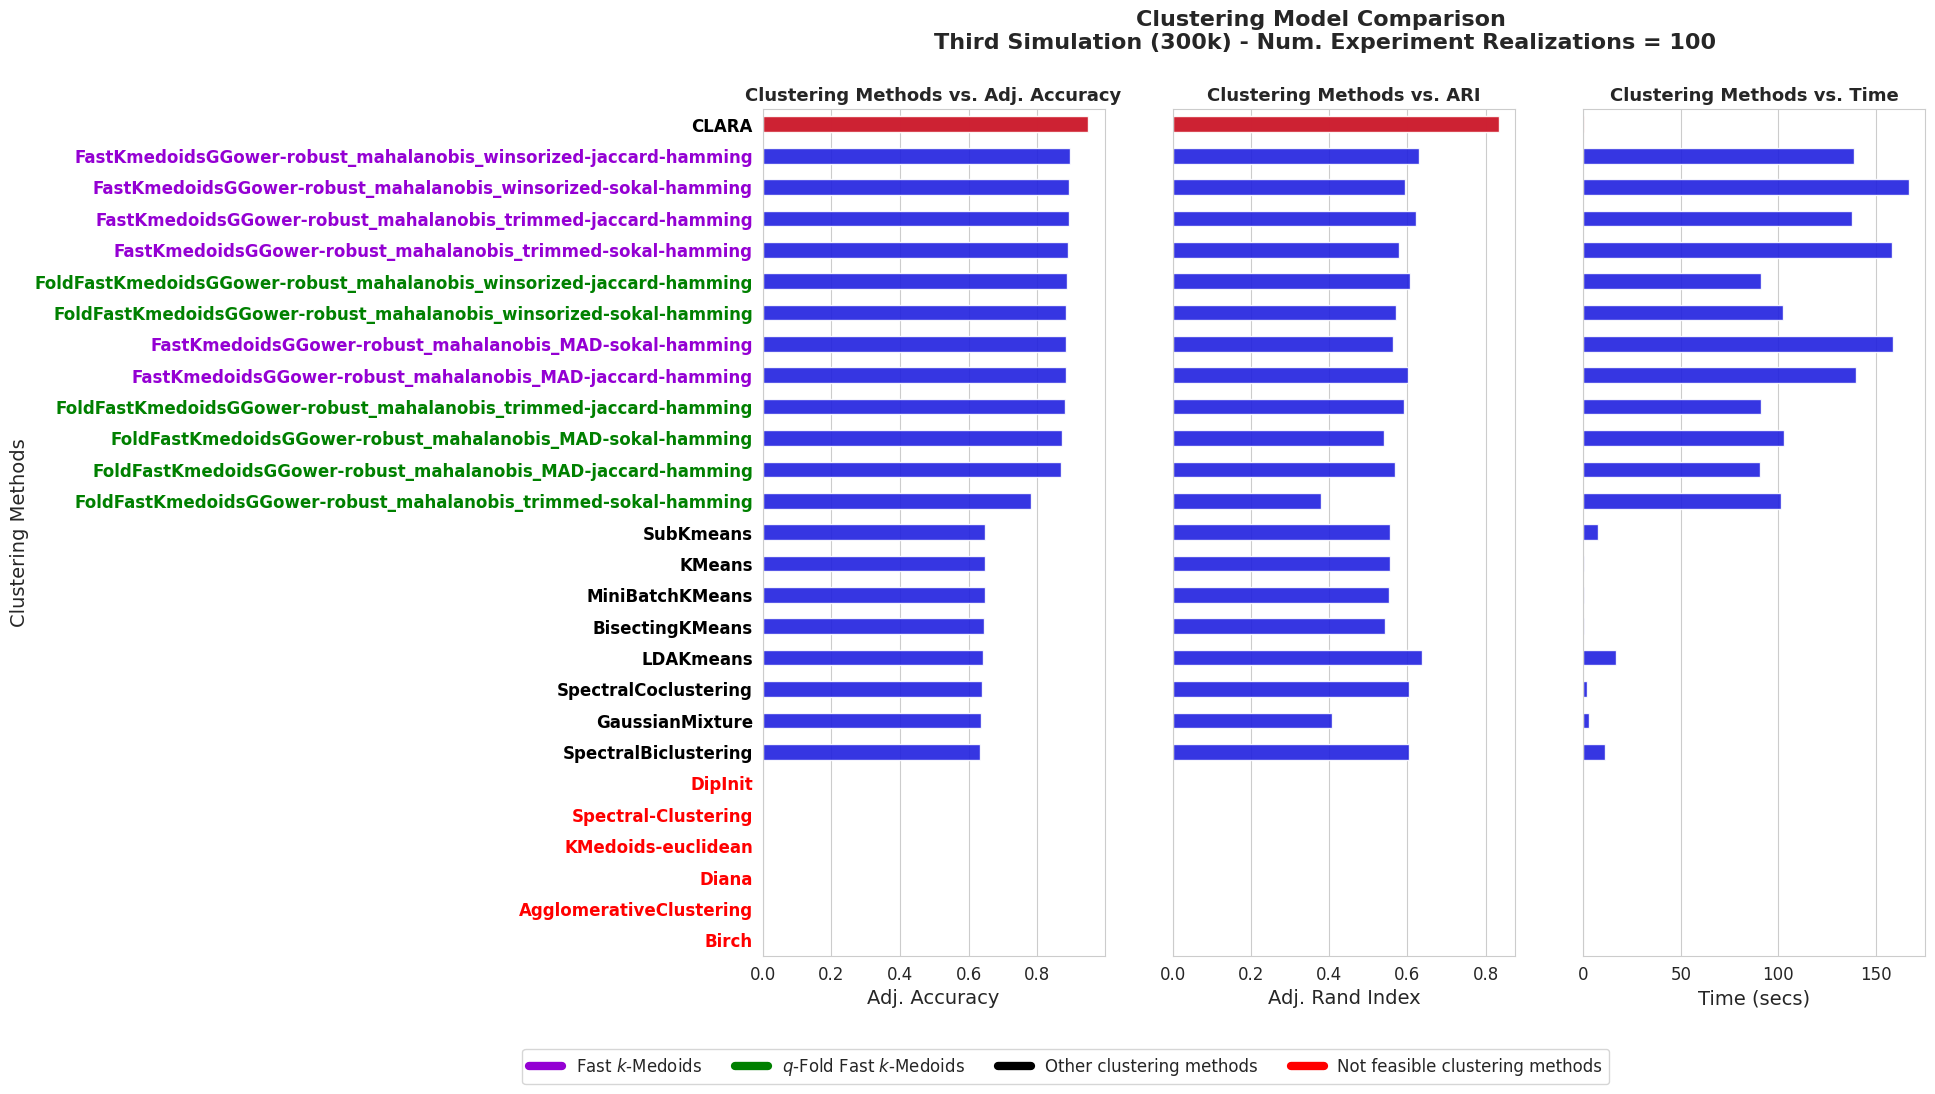

In [26]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nThird Simulation (300k) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_simu_4_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [27]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [28]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
CLARA,0.334029,0.948451,0.833128
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,138.681984,0.894022,0.630690
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,166.905306,0.893266,0.593701
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,137.837532,0.890859,0.621187
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,158.335932,0.888671,0.579359
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,91.275143,0.885166,0.605471
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,102.153538,0.884093,0.569728
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,158.814599,0.883398,0.564172
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,139.690464,0.882592,0.600920


In [12]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
MiniBatchKMeans,0.158736,0.940379,0.853819
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,96.805782,0.881969,0.718133
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,96.413069,0.869642,0.696396
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,95.391142,0.870075,0.688750
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,91.494450,0.852172,0.648384
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,89.420037,0.841109,0.634662
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,89.760816,0.835995,0.625043
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,88.972284,0.836040,0.619665
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,92.052074,0.831951,0.609566


---

In [27]:
random_state_mds = 35084

X, y, outliers_idx = get_simulation_4(random_state=random_state_mds, return_outlier_idx=True)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.008, random_state=random_state_mds, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

# Time: 52 secs

/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [28]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


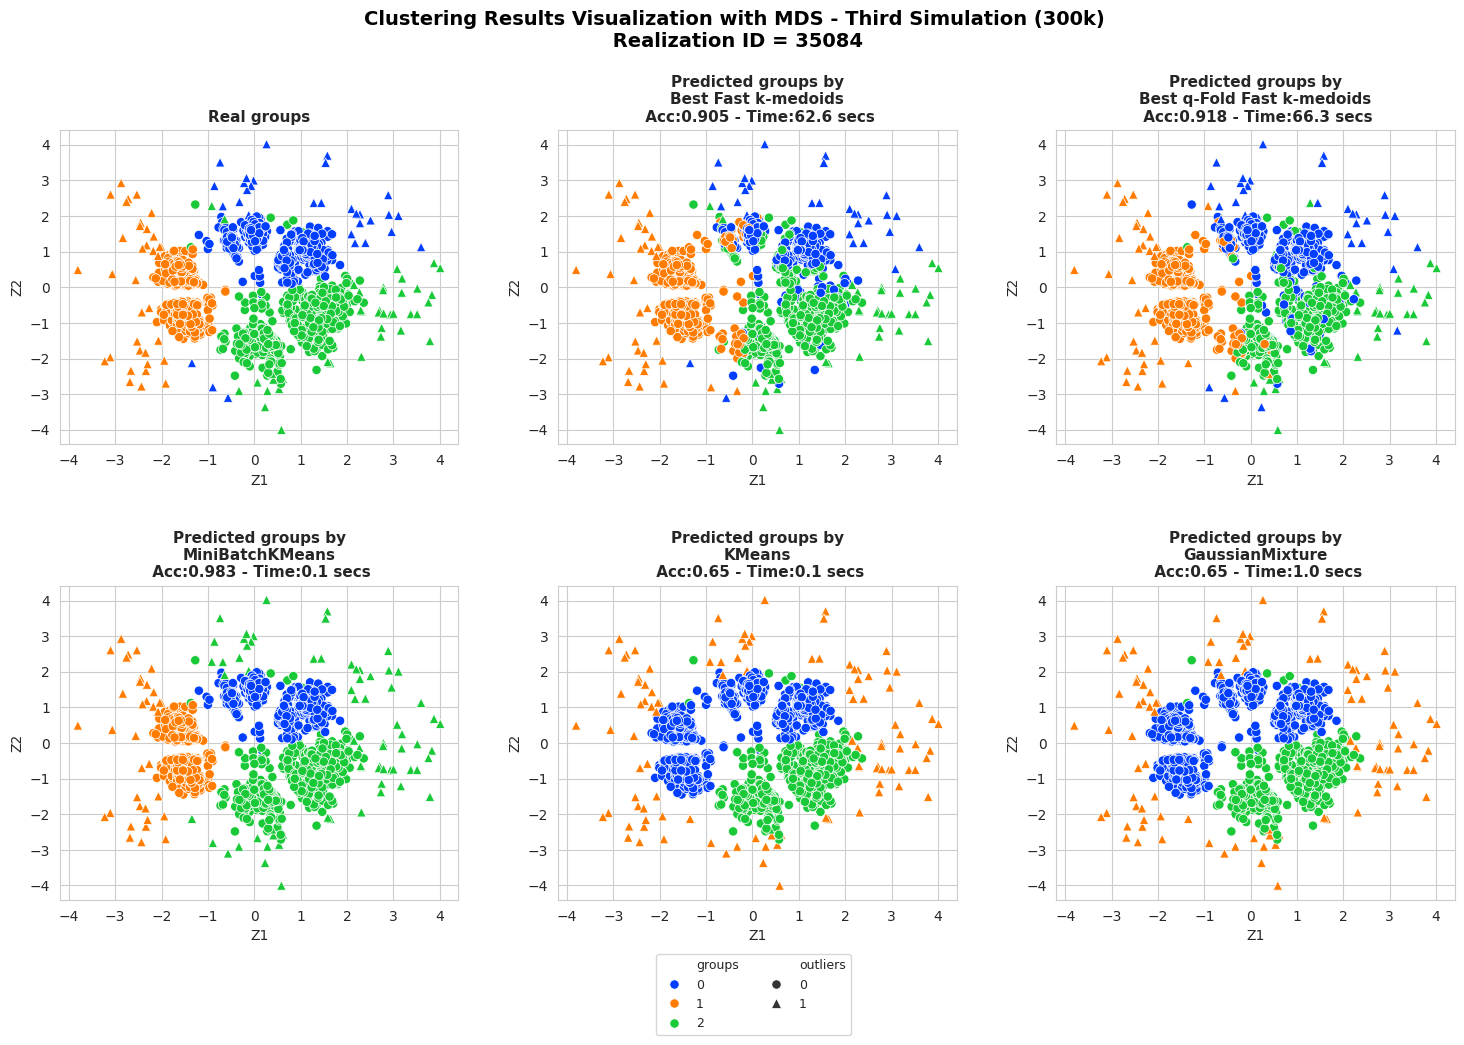

In [29]:
plot_filename = f'mds_plot_exp_4_simu_4_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_3')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Third Simulation (300k)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)